In [1]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 24.5 MB/s eta 0:00:00


In [2]:
import transformers
print("Transformers version:", transformers.__version__)

Transformers version: 4.47.0


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BitsAndBytesConfig
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, TrainerCallback
from peft import LoraConfig, get_peft_model
from sklearn.metrics import confusion_matrix, classification_report
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, TrainerCallback, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
import torch
import torch.nn as nn


from transformers import (AutoTokenizer, AutoModelForCausalLM, TrainingArguments, 
                          Trainer, TrainerCallback, BitsAndBytesConfig)
from peft import LoraConfig, get_peft_model
from sklearn.metrics import confusion_matrix, classification_report

# -----------------------------
# 1. Data Access & Preprocessing
# -----------------------------
TRAIN_PATH = "/kaggle/input/bengali-hate/RawData.csv"
TEST_PATH = "/kaggle/input/bengali-hate/testing_data.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print("Training Data Sample:")
print(train_df.head())

# Map string labels to integer IDs.
label2id = {label: idx for idx, label in enumerate(train_df['Sentiment'].unique())}
id2label = {idx: label for label, idx in label2id.items()}
print("Label mapping:", label2id)

train_df['Sentiment'] = train_df['Sentiment'].map(label2id)
test_df['Sentiment'] = test_df['Sentiment'].map(label2id)

# -----------------------------
# 2. Define Custom Dataset
# -----------------------------
class BanglaHateDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=256):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        text = str(self.dataframe.iloc[idx]['comment'])
        label = int(self.dataframe.iloc[idx]['Sentiment'])
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        encoding['labels'] = torch.tensor(label, dtype=torch.long)
        return encoding

# -----------------------------
# 3. Load Tokenizer and Create Datasets
# -----------------------------
model_name = "unsloth/llama-3-8b-bnb-4bit"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset = BanglaHateDataset(train_df, tokenizer, max_length=256)
test_dataset = BanglaHateDataset(test_df, tokenizer, max_length=256)

# -----------------------------
# 4. Define a Custom Model for Sequence Classification
# -----------------------------
class LlamaForSequenceClassification(nn.Module):
    def __init__(self, model_name, num_labels):
        super(LlamaForSequenceClassification, self).__init__()
        # Configure 4-bit quantization.
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",  # or "fp4" if desired
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True
        )
        
        # Load the base LLaMA model with quantization config.
        self.llama = AutoModelForCausalLM.from_pretrained(
            model_name,
            quantization_config=bnb_config,
            device_map="auto"
        )
        
        self.num_labels = num_labels
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.llama.config.hidden_size, num_labels)
    
        self.config = self.llama.config

    def forward(self, input_ids, attention_mask, labels=None, **kwargs):
        # Remove any unexpected keyword arguments if present.
        if "inputs_embeds" in kwargs:
            kwargs.pop("inputs_embeds")
            
        outputs = self.llama.model(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        last_hidden_state = outputs[0]  # shape: (batch_size, seq_length, hidden_size)
        
        # Mean pooling over the sequence length dimension.
        pooled_output = last_hidden_state.mean(dim=1)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return {"loss": loss, "logits": logits}

num_labels = len(label2id)
print(f"Number of labels: {num_labels}")

model = LlamaForSequenceClassification(model_name, num_labels)

# -----------------------------
# 5. Configure and Apply LoRA (using PEFT)
# -----------------------------
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)
print("LoRA-enabled model:")
print(model)

# -----------------------------
# 6. Set Up Training with Hugging Face Trainer
# -----------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy}

class LossHistory(TrainerCallback):
    def __init__(self):
        self.losses = []
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            self.losses.append(logs["loss"])

loss_history = LossHistory()


Training Data Sample:
                                             comment    Sentiment
0   এমন ভালবাসা ইসলাম সমর্থন করে না বিয়ের আগে কোন...  Hate Speech
1   নোংরা মনমানসিকতার একটা লিমিট আছে  এখানে  এই প...  Hate Speech
2   হারি আপ ব্রাদার  অ্যাটেনশন please believe me ...  Hate Speech
3   এ নাটকের সবথেকে বাজে দিক হচ্ছে  এখানে বাবা মা...  Hate Speech
4   এটা অনেক কষ্টের  আসলে মেয়েরা অনেক স্বার্থপর  ...  Hate Speech
Label mapping: {'Hate Speech': 0, 'Normal Speech': 1}


tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Number of labels: 2


config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:186: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

LoRA-enabled model:
PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (llama): LlamaForCausalLM(
        (model): LlamaModel(
          (embed_tokens): Embedding(128256, 4096, padding_idx=128255)
          (layers): ModuleList(
            (0-31): 32 x LlamaDecoderLayer(
              (self_attn): LlamaSdpaAttention(
                (q_proj): lora.Linear(
                  (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=4096, out_features=8, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=8, out_features=4096, bias=False)
                  )
                  (lora_embedding_A): ParameterDict()
                

Starting training...


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.263700,0.074827,0.988372
2,0.119900,0.056698,0.988372


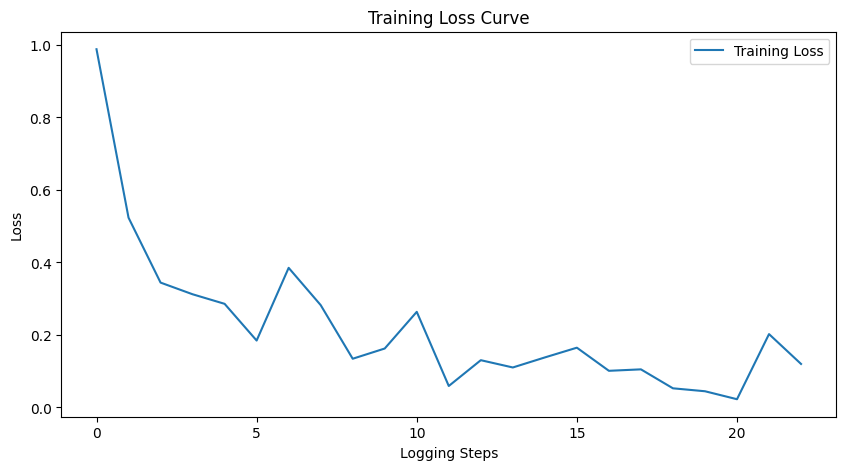

Evaluating on test data...


Evaluation results:
{'eval_loss': 0.07482689619064331, 'eval_accuracy': 0.9883720930232558, 'eval_runtime': 159.9422, 'eval_samples_per_second': 1.613, 'eval_steps_per_second': 0.406, 'epoch': 2.0}
Classification Report:
               precision    recall  f1-score   support

  Hate Speech       0.99      0.99      0.99       157
Normal Speech       0.98      0.99      0.99       101

     accuracy                           0.99       258
    macro avg       0.99      0.99      0.99       258
 weighted avg       0.99      0.99      0.99       258



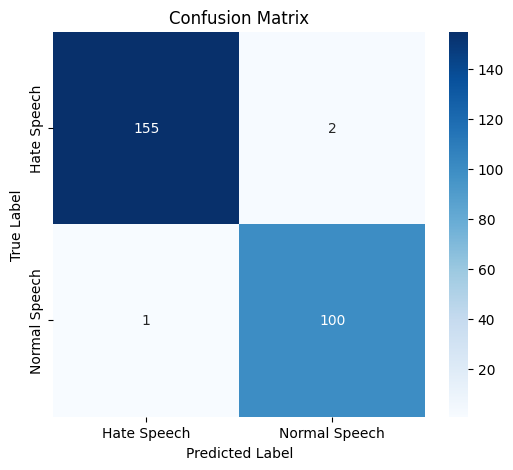

In [4]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[loss_history]
)

# -----------------------------
# 7. Training
# -----------------------------
print("Starting training...")
train_result = trainer.train()
trainer.save_model()  # Save the final model

# -----------------------------
# 8. Visualize the Training Loss Curve
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(loss_history.losses, label="Training Loss")
plt.xlabel("Logging Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

# -----------------------------
# 9. Evaluation on Test Data
# -----------------------------
print("Evaluating on test data...")
eval_result = trainer.evaluate()
print("Evaluation results:")
print(eval_result)

predictions_output = trainer.predict(test_dataset)
preds = np.argmax(predictions_output.predictions, axis=-1)
labels = predictions_output.label_ids

print("Classification Report:")
print(classification_report(labels, preds, target_names=[id2label[i] for i in range(num_labels)]))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[id2label[i] for i in range(num_labels)],
            yticklabels=[id2label[i] for i in range(num_labels)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()